# The question that this file answers is:
How effective is the team in blocking passing lanes and shot attempts?

## Configuration

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle, Arc, Circle
import numpy as np
from sqlalchemy import create_engine

# Configuration
PG_PASSWORD = "[KSiO^`9??V\K=?W2>Z:`"
PG_USER = "busit_79"
PG_HOST = "fuji.ucll.be"
PG_PORT = "52425"
PG_DATABASE = "international_week"
DB_URL = f"postgresql+psycopg2://{PG_USER}:{PG_PASSWORD}@{PG_HOST}:{PG_PORT}/{PG_DATABASE}?sslmode=require"
MY_TEAM_ID = "bw9wm8pqfzcchumhiwdt2w15c"

<>:9: SyntaxWarning: invalid escape sequence '\K'
<>:9: SyntaxWarning: invalid escape sequence '\K'
/var/folders/ll/pl5gvz5s3sb915pdxqdvhp8w0000gn/T/ipykernel_6076/174072608.py:9: SyntaxWarning: invalid escape sequence '\K'
  PG_PASSWORD = "[KSiO^`9??V\K=?W2>Z:`"


## Step 1.
Drawing and plotting the pitch/football field

<Axes: >

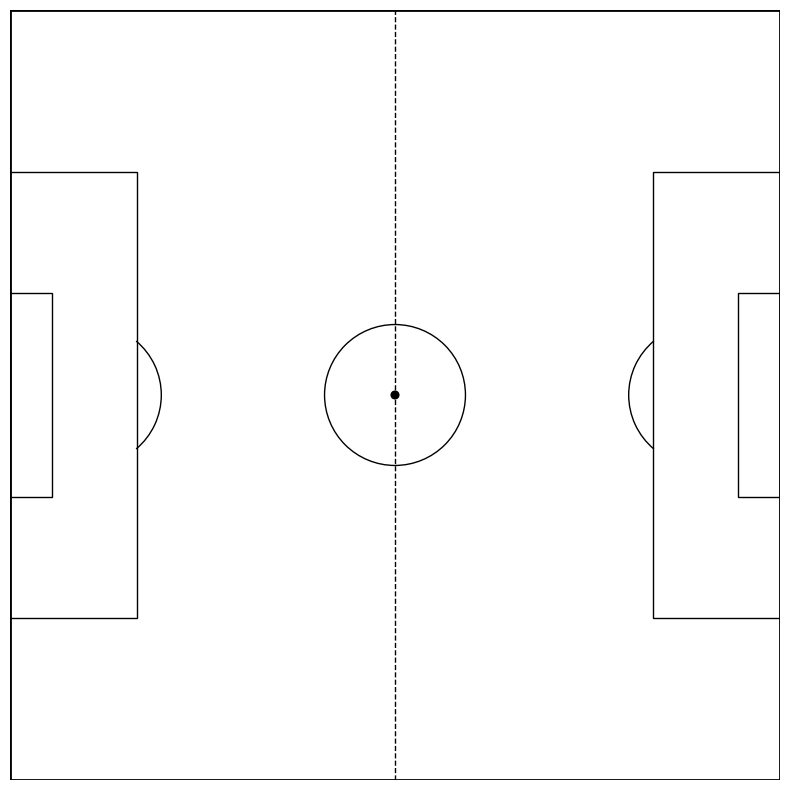

In [7]:
def draw_detailed_pitch(ax):
    # These plots are the pitch outline & centre line
    ax.plot([0, 100], [0, 0], color="black", linewidth=2)  # bottom touchline
    ax.plot([0, 100], [100, 100], color="black", linewidth=2)  # top touchline
    ax.plot([0, 0], [0, 100], color="black", linewidth=2)  # left goal line
    ax.plot([100, 100], [0, 100], color="black", linewidth=2)  # right goal line
    ax.plot([50, 50], [0, 100], color="black", linewidth=1, linestyle="dashed")  # halfway line
    
    # Penalty Area and Goal Area
    penalty_left = Rectangle((0, 21.1), 16.5, 57.8, linewidth=1, edgecolor="black", facecolor="none")
    penalty_right = Rectangle((83.5, 21.1), 16.5, 57.8, linewidth=1, edgecolor="black", facecolor="none")
    goal_left = Rectangle((0, 36.8), 5.5, 26.4, linewidth=1, edgecolor="black", facecolor="none")
    goal_right = Rectangle((94.5, 36.8), 5.5, 26.4, linewidth=1, edgecolor="black", facecolor="none")
    
    # Goals
    goal_left_line = Rectangle((0, 44.4), -2, 11.2, linewidth=1, edgecolor="black", facecolor="none")
    goal_right_line = Rectangle((100, 44.4), 2, 11.2, linewidth=1, edgecolor="black", facecolor="none")
    
    # Centre Circle and Spot
    centre_circle = Circle((50, 50), 9.15, color="black", fill=False, linewidth=1)
    centre_spot = Circle((50, 50), 0.5, color="black")
    
    # Arcs
    left_arc = Arc((10.5, 50), height=18.3, width=18.3, angle=0, theta1=310, theta2=50, color="black", linewidth=1)
    right_arc = Arc((89.5, 50), height=18.3, width=18.3, angle=0, theta1=130, theta2=230, color="black", linewidth=1)
    
    # Add all elements to the axes
    for element in [penalty_left, penalty_right, goal_left, goal_right,
                   goal_left_line, goal_right_line, centre_circle, centre_spot,
                   left_arc, right_arc]:
        ax.add_patch(element)
    
    # Set axes properties
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_aspect("equal")
    ax.axis("off")
    
    return ax

# Draw the pitch
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111)
draw_detailed_pitch(ax)

## Step 2.
Create the success and failed actions along with a blue area that highlights defensive focus zones and plot it

In [8]:
def plot_defensive_actions(ax, defensive_actions):
    # Convert result to numeric if it isn't already
    defensive_actions['result'] = pd.to_numeric(defensive_actions['result'], errors='coerce')
    
    # Map numeric results to success/failure
    success_codes = [0, 10, 11]  # BLOCKED, SUCCESS, WON
    fail_codes = [1, 3, 4]       # COMPLETE, INCOMPLETE, LOST
    
    # Filter actions
    success = defensive_actions[defensive_actions['result'].isin(success_codes)]
    failed = defensive_actions[defensive_actions['result'].isin(fail_codes)]
    
    # Plot density for all defensive actions first
    if not defensive_actions.empty:
        sns.kdeplot(
            x=defensive_actions['start_x'],
            y=100 - defensive_actions['start_y'],
            levels=5,
            color='#0260f7',
            alpha=0.25,
            ax=ax,
            zorder=1,
            bw_adjust=0.6,  
            fill=True       
        )
    
    # Plot successful actions
    if not success.empty:
        ax.scatter(
            success['start_x'],
            100 - success['start_y'],
            c='#2ecc71',
            s=120,
            edgecolors='black',
            linewidths=0.5,
            alpha=0.9,
            label=f'Successful',
            zorder=3
        )
    
    # Plot failed actions
    if not failed.empty:
        ax.scatter(
            failed['start_x'],
            100 - failed['start_y'],
            c='#e74c3c',
            s=120,
            marker='x',
            linewidths=2,
            alpha=0.9,
            label=f'Failed',
            zorder=3
        )
    
    if not success.empty or not failed.empty:
        ax.legend(loc='upper right', framealpha=1)
    else:
        print("No defensive actions matched the criteria")

## Step 3.
- Print metrics about defensive success rate and pass diruptions in danger zone
- Yellow To Red area: Shows where opponent passes failed

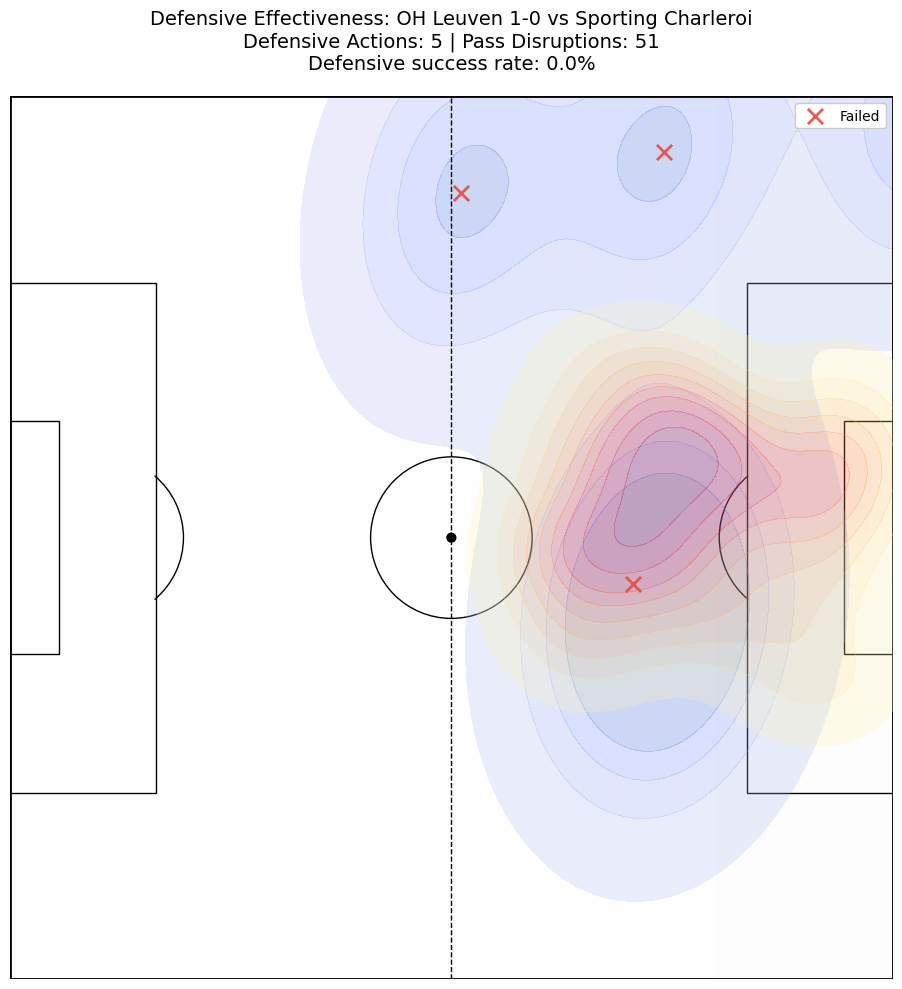

 OH Leuven 1-0 Sporting Charleroi 
 Match id: 77idfj6cmoadi2223efythatw 


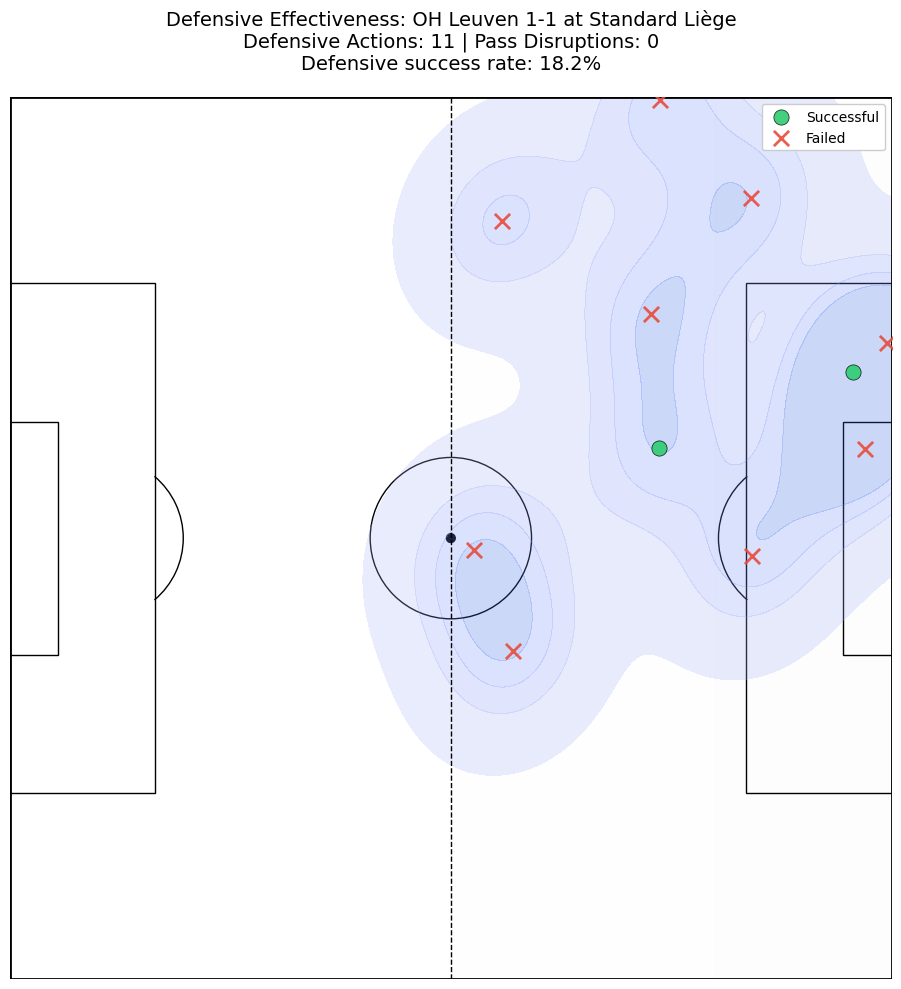

 OH Leuven 1-1 Standard Liège 
 Match id: 741sm8f1osrj6qvq54ql5sv84 


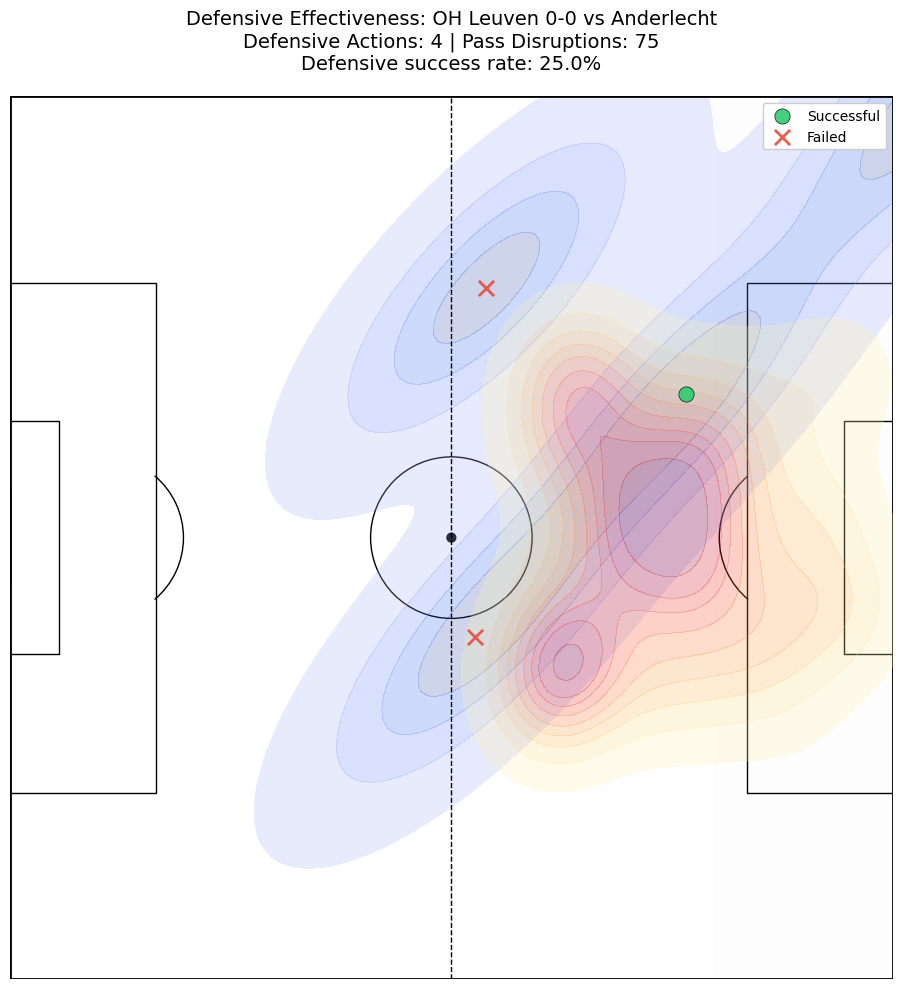

 OH Leuven 0-0 Anderlecht 
 Match id: 70wtfxx5kccxl5sxj1bvcd8us 


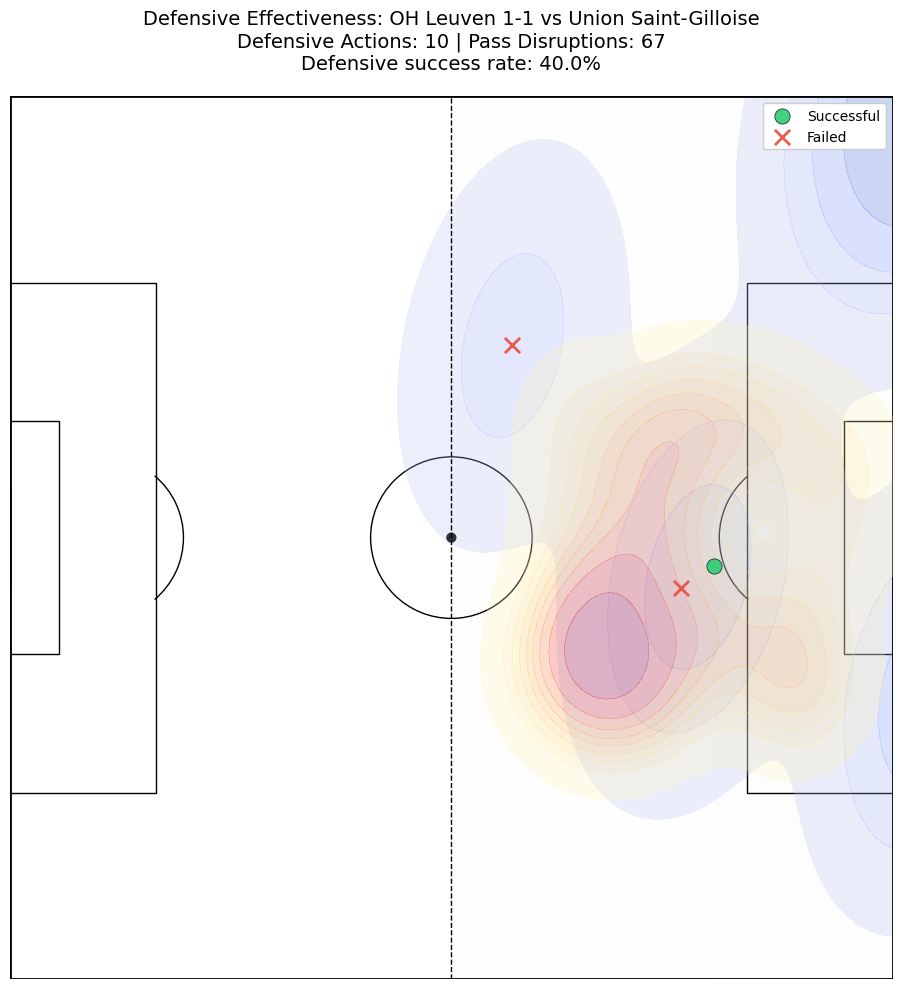

 OH Leuven 1-1 Union Saint-Gilloise 
 Match id: 6y80kic6abtlkzmkr4oiejkt0 


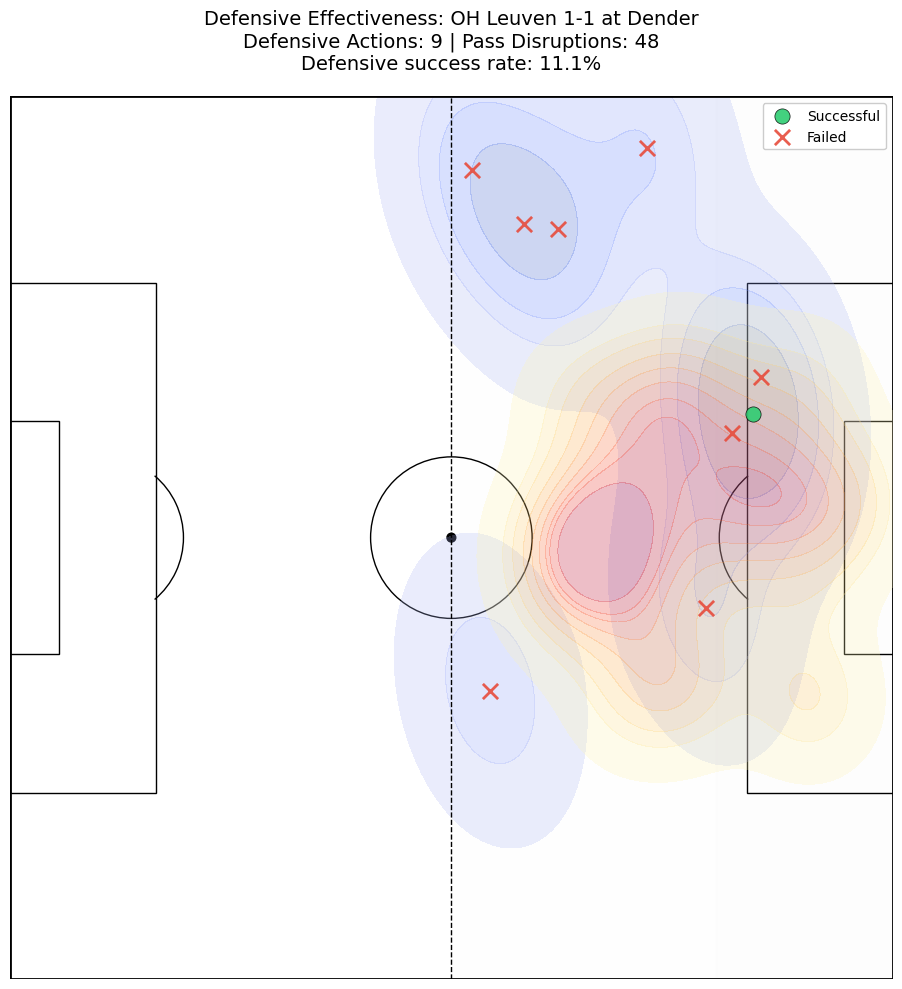

 OH Leuven 1-1 Dender 
 Match id: 6vul2r4nef60spfw1s0m9nwno 


In [9]:
def analyze_defensive_effectiveness():
    engine = create_engine(DB_URL, pool_size=3, pool_recycle=300)
    
    try:
        with engine.connect() as conn:
            # Get team name (in this case it is set to OH Leuven)
            my_team_name = pd.read_sql(
                f"SELECT team_name FROM teams WHERE team_id = '{MY_TEAM_ID}'",
                conn
            ).iloc[0,0]
            
            # Get matches to analyze
            matches = pd.read_sql(f"""
                SELECT m.match_id, m.home_team_id, m.away_team_id, 
                       m.home_score, m.away_score,
                       home.team_name as home_team,
                       away.team_name as away_team
                FROM matches m
                JOIN teams home ON m.home_team_id = home.team_id
                JOIN teams away ON m.away_team_id = away.team_id
                WHERE m.home_team_id = '{MY_TEAM_ID}' OR m.away_team_id = '{MY_TEAM_ID}'
                ORDER BY m.match_date DESC
                LIMIT 5
            """, conn)
            
            for _, match in matches.iterrows():
                match_id = match['match_id']
                is_home = match['home_team_id'] == MY_TEAM_ID
                opponent = match['away_team'] if is_home else match['home_team']
                score = f"{match['home_score']}-{match['away_score']}"
                
                # Get defensive actions
                defensive_actions = pd.read_sql(f"""
                    SELECT sa.start_x, sa.start_y, sa.result 
                    FROM spadl_actions sa
                    WHERE sa.game_id = '{match_id}'
                    AND sa.team_id = '{MY_TEAM_ID}'
                    AND sa.action_type IN ('3', '4', '5')
                    AND sa.start_x > 50
                """, conn)

                # Get opponent failed passes in danger zones
                disrupted_passes = pd.read_sql(f"""
                    SELECT x, y
                    FROM matchevents
                    WHERE match_id = '{match_id}'
                    AND team_id = '{match['away_team_id'] if is_home else match['home_team_id']}'
                    AND x > 60
                    AND y BETWEEN 30 AND 70
                    AND result != 'complete'
                """, conn)
                
                # Create figure
                fig = plt.figure(figsize=(16, 10))
                ax = fig.add_subplot(111)
                
                # Draw detailed pitch
                draw_detailed_pitch(ax)
                
                # Plot defensive actions
                plot_defensive_actions(ax, defensive_actions)
                
                # Add pass disruption heatmap
                if not disrupted_passes.empty:
                    sns.kdeplot(
                        x=disrupted_passes['x'],
                        y=100 - disrupted_passes['y'],
                        cmap='YlOrRd',
                        fill=True,
                        levels=10,
                        alpha=0.25,
                        ax=ax,
                        zorder=2
                    )
                
                # Add title with match info
                venue = "vs" if is_home else "at"
                title = f"Defensive Effectiveness: {my_team_name} {score} {venue} {opponent}\n"
                title += f"Defensive Actions: {len(defensive_actions)} | Pass Disruptions: {len(disrupted_passes)}"
                if not defensive_actions.empty:
                    success = defensive_actions['result'].isin([0, 10, 11])
                    success_rate = success.mean() * 100
                    title += f"\nDefensive success rate: {success_rate:.1f}%"
                plt.title(title, pad=20, fontsize=14)
                
                # Add defensive third shading
                ax.add_patch(Rectangle((50, 0), 50, 100, color='#f9f9f9', alpha=0.1, zorder=0))
                ax.add_patch(Rectangle((80, 0), 20, 100, color='#f9f9f9', alpha=0.2, zorder=0))
                
                plt.tight_layout()
                plt.show()
                
                # Print metrics
                print(f" {my_team_name} {score} {opponent} \n Match id: {match_id} ")

    except Exception as e:
        print(f"Error: {e}")
    finally:
        engine.dispose()

# Run the analysis
analyze_defensive_effectiveness()

## Step 4. Explaining the visualization and metrics
### Visualisations
- Green dot:
    - Meaning: successful defensive actions (tackles, interceptions, blocks)
    - Strategic Insight: Shows where the team consistently wins back possession
- Red X:
    - Meaning: failed defensive actions
    - Strategic Insight: Reveals vulnerable areas (that need improvement)
- Blue area:
    - Meaning: highlights defensive focus zone (more dense = more focus)
    - Strategic Insight: Identify the team's defensive focus zones
- Yellow-to-Red area 
    - Meaning: shows where opponent passes failed
    - Strategic Insight: Highlights where your teams pressure forces opponents errors
### Metrics
- Defensive actions --> Total attempted tackles/interceptions/blocks in high-risk zones
- Pass disruptions --> Counts how often the team prevented the opponents from completing passes
- Defensive success rate --> Percentage of defensive actions that successfully stopped opponent attacks